# Gaussian Mixture Models

We will now take a look at Gaussian mixture models (GMM), which is a powerful tool for estimation beyond simple clustering.

We begin with the imports as usual:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Motivating GMM

Let's take a look at some of the weaknesses of k-means and think about how we could improve the clustering model. For example, consider the following data, in which the algorithm performs relatively well:

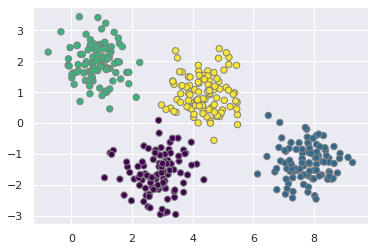

In [2]:
# Generate some data
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, ec='gray', cmap='viridis');

We might expect that the clustering assignment is easier for certain points than others: the two middle clusters appear to have a slight overlap, so it is reasonable to think that the algorithm might not have complete confidence in the clustering assignment for points between them. 

The k-means model has no intrinsic measure of probability or uncertainty of cluster assignments: it simply assigns the label of the closest cluster center, essentially placing a circle (or hyper-sphere in higher dimensions) around these centers. The radius of such circles act as a hard cutoff for cluster assignment within the training set. We can visualize this with the following function:

In [3]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, ec='gray', cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', ec='k', lw=3, alpha=0.5, zorder=1))

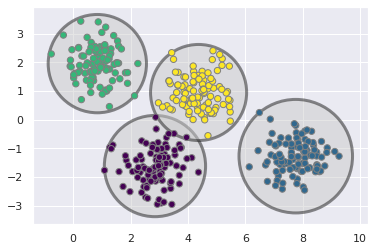

In [4]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

An important observation is that the k-means algorithm has no built-in way of accounting for clusters shapes other than circular. If we transform this data, the cluster assignments become muddled:

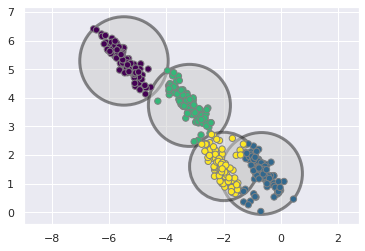

In [5]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

We can clearly see that these transformed clusters are non-circular, thus these circular clusters that k-means encountered are a poor fit. We might imagine addressing this particular situation by preprocessing the data (with PCA, for example), but in practice there is no guarantee that such a operation will circularize the individual data.

Therefore, k-means has two big disadvantages: it lacks flexibility in cluster shape, and lacks probabilistic cluster assignment. There are several situations in which we might want to address these issues, and turns out that Gaussian mixture models can do precisely that for us!

## Generalizing E-M: Gaussian Mixture Models

A Gaussian mixture model (GMM) seeks to find a mixture of multi-dimensional Gaussian probability distributions that best model a given input dataset. In the simplest case, GMMs can be used for finding clusters the same way as k-means can:

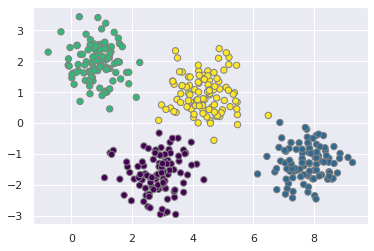

In [6]:
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, ec='gray', cmap='viridis');

GMM contains a probabilistic model under the hood, and its thanks to that that it is also possible to find probabilistic cluster assignments using the `predict_proba`:

In [7]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.463 0.    0.537]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]]


We can make the size of each point be proportional to the certainty of its prediction to make up for a great visualization of this:

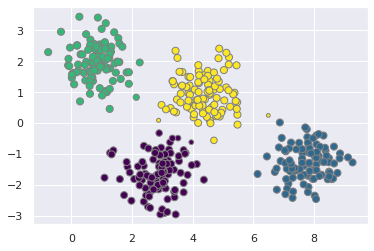

In [8]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', ec='gray', s=size);

A Gaussian mixture model uses an expectation-maximization approach that does the following:

1. Choose starting guesses for the location and shape
2. Repeat until converged:
    1. _E-step_: for each point, find weights encoding the probability of membership in each cluster
    2. _M-step_: for each cluster, update its location, normalization, and shape based on _all_ points, making use of the weights
    
This results in a smooth Gaussian model, as opposed to a hard-edged sphere. Just as with k-means, this algorithm can sometimes miss the globally optimal solution, and multiple random initializations are used in practice.

We will use the following function to visualize the GMM clusters by drawing ellipses:

In [9]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', ec='gray', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

We can now take a look at the result of this four-component GMM for our initial data:

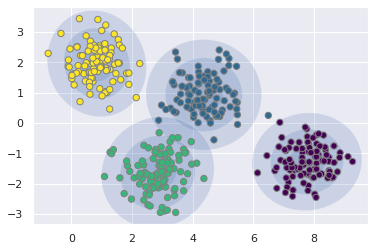

In [10]:
gmm = GMM(n_components=4, random_state=42)
plot_gmm(gmm, X)

Similarly, we can do the same to fit our stretched dataset:

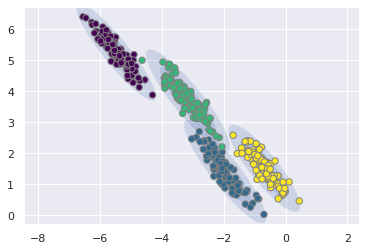

In [11]:
gmm = GMM(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

We can clearly see that GMM addresses the two main practical issues with k-means.

### Choosing the covariance type

The covariance types is a hyperparameter that controls the degree of freddom in the shape of each cluster; it is essential to set this carefully for any given problem. The default for `GaussianMixture` is `covariance_type='full'`, which is a more complicated and computationally expensive model, which allows each cluster to be modeled as an ellipse with arbitrary orientation. There is also `covariance_type='diag'`, which means that the size of the cluster along each dimensions can be set independently, with the resulting ellipse constrained to align with the axes. A slightly simpler and faster model is `covariance_type='spherical'`, which constrains the shape of the cluster such that all dimensions are equal (similar to that of k-means, but not entirely equivalent). Lastly, there is `covariance_type='tied'`, where all components share the same general covariance matrix.

There is a great visual representation showing the differences between all of those in the Scikit-Learn's [Gaussian mixture model user guide](https://scikit-learn.org/stable/modules/mixture.html#gmm):

![Comparison between covariance types](https://scikit-learn.org/stable/_images/sphx_glr_plot_gmm_covariances_0011.png)

## GMM as _Density Estimation_

GMM is often used as a clustering algorithm, but fundamentally it is an algorithm for _density estimation_. This means that the result of a GMM fit to some data is a generative probabilistic model describing the distribution of the data.

As example, consider the following data:

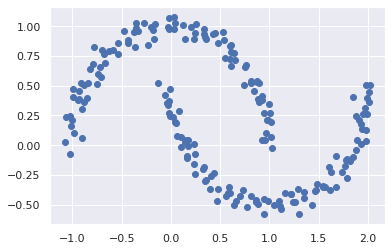

In [12]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

If we try to fit this data to a two-component GMM, the results are not particularly useful:

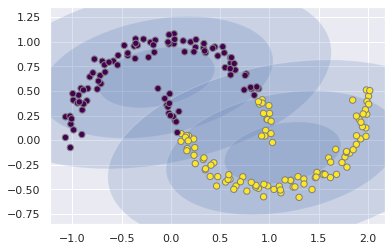

In [13]:
gmm2 = GMM(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

If we instead use many more components, we find a fit that is much closer to the input data:

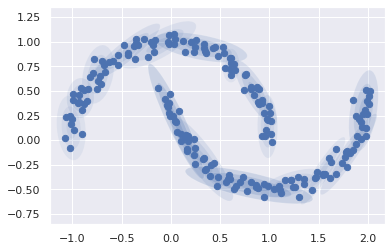

In [14]:
gmm16 = GMM(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

In this case, the mixture of Gaussians serves to model the overall _distribution_ of the input data, instead of trying to find separated clusters of data. This means that the GMM gives us the recipe to generate new random data that has a similar distribution to that of our input. For example, this are 400 new points drawn from this 16-component GMM:

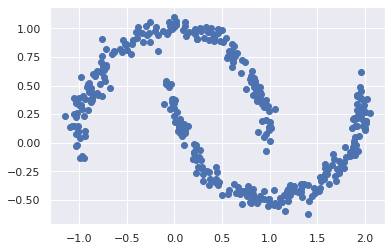

In [15]:
Xnew = gmm16.sample(400)[0]
plt.scatter(Xnew[:, 0], Xnew[:, 1]);

### How many components?

GMM being a generative model gives us the means of determining the optimal number of components for a given dataset. Given that a generative model is a probability distribution for the dataset, we can simply evaluate the _likelihood_ of the data under the model, using cross-validation to avoid over-fitting. Another means of correcting for over-fitting is to adjust the model likelihoods using some analytic criterion such as the [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) or the [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion). 

Let's look at the AIC and BIC as functions of the number of GMM components for our dataset:

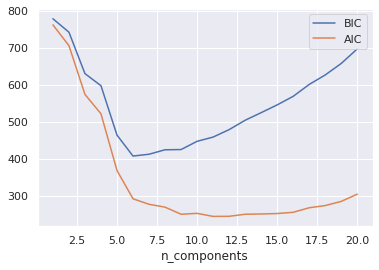

In [16]:
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

The optimal number of clusters is the value that minimizes the AIC or BIC, depending on which criterion we wish to use. BIC, for example, recommends a simpler model with around 6 components.

The important point here is that the choice of number of components measures how well GMM works as a _density estimator_, not as a _clustering algorithm_.

## Example: GMM for Generating New Data

We can use the idea of using GMM as a generative model to generate, for example, new handwritten digits from the standard digits dataset we have used before.

As an example of using GMM as a generative model to create new instances of data, we will take a look at generating _new handwritten digits_ from the standard digits dataset we've used before:

We will start with loading the digits data:

In [17]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

For good measure, we'll take a look at the first 100 of these to recall what we're looking at:

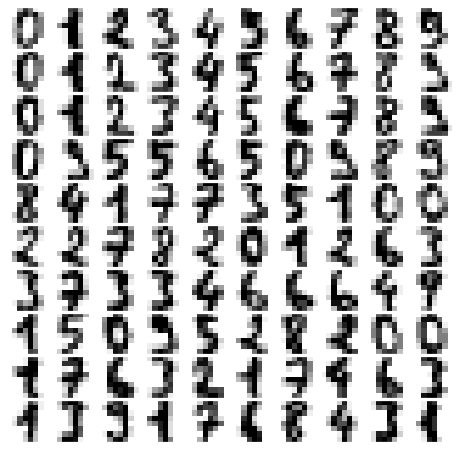

In [18]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

We have nearly 1800 digits in 64 dimensions, and we can build a GMM on top of this data to generate much more. GMMs can have a difficult time converging in such a high-dimensional space, so we will start reducing the dimensionality with PCA, asking it to preserve 99% of the variance in the projected data:

In [19]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

In this particular case, we were able to reduce the dimensionality by nearly 1/3 with almost no information loss! With this project data, we can use the AIC to analyze how much GMM components we should use:

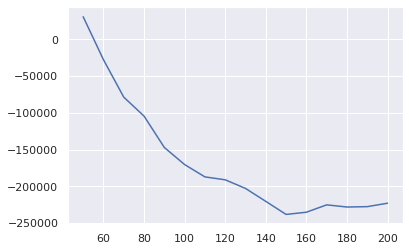

In [20]:
n_components = np.arange(50, 210, 10)
models = [GMM(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

We can see that around 150 minimizes the AIC, so we will use this model. Let's fit the model and confirm that it has converged: 

In [21]:
gmm = GMM(150, covariance_type='full', random_state=0)
gmm.fit(data)
gmm.converged_

True

We can now draw some new generated samples from within this 41-dimensional projected space, using the GMM as a generative model:

In [22]:
data_new = gmm.sample(100)[0]
data_new.shape

(100, 41)

Finally, we will use the inverse transform of the PCA to construct the new 64-dimensional digits:

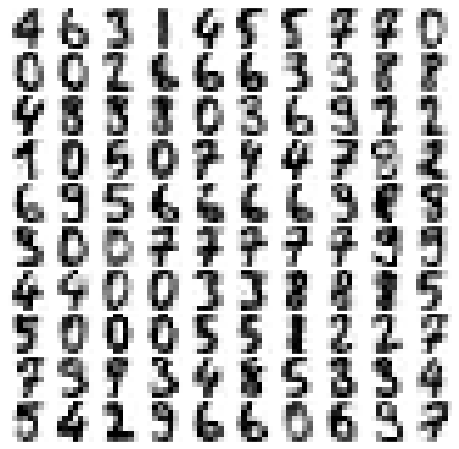

In [23]:
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)

We can see that the results certainly look like plausible digits from the original dataset, despite the fact that we just generated them artificially!